In [63]:
import os
import time
from pathlib import Path
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim


print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.7.0+cu118
CUDA: True
GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [64]:
# 路径配置
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data" / "celeba"
IMG_DIR = DATA_DIR / "img_align_celeba"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
CHECKPOINT_DIR = OUTPUT_DIR / "checkpoints_fast"
RESULTS_DIR = OUTPUT_DIR / "results_fast"

for d in [OUTPUT_DIR, CHECKPOINT_DIR, RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("path:")
print(f"Image: {IMG_DIR}")
print(f"Print: {CHECKPOINT_DIR}")

if IMG_DIR.exists():
    n_images = len(list(IMG_DIR.glob("*.jpg")))
    print(f"find {n_images} pictures")

path:
Image: C:\Users\Yiyi\Deep learning\project\data\celeba\img_align_celeba
Print: C:\Users\Yiyi\Deep learning\project\outputs\checkpoints_fast
find 202599 pictures


In [65]:
# 快速训练配置 
class FastConfig:
    # 图像尺寸 - 改为64x64输出
    HR_SIZE = 64  # 从128改为64
    SCALE = 2
    LR_SIZE = HR_SIZE // SCALE  # 32
    
    # 数据集 - 使用更少数据加快训练
    USE_SUBSET = True
    SUBSET_SIZE = 50000  # 只用5万张图片
    TRAIN_RATIO = 0.95
    VAL_RATIO = 0.05
    
    # 模型架构 - 轻量化
    IN_NC = 3
    OUT_NC = 3
    NF = 64
    NB = 8  # 从16减到8个RRDB块
    
    # 训练参数 - 5个epoch
    BATCH_SIZE = 32  # 增大批次加快训练
    NUM_EPOCHS = 20   # 训练10个epoch
    LR_G = 2e-4      # 提高学习率
    LR_D = 2e-4
    BETA1 = 0.9
    BETA2 = 0.999
    
    # 损失权重 - 去掉VGG感知损失
    PIXEL_WEIGHT = 1.0  # 提高像素损失权重
    USE_PERCEPTUAL = False  # 关闭VGG
    GAN_WEIGHT = 5e-3
    
    # 硬件
    NUM_WORKERS = 0
    PIN_MEMORY = False
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 日志
    LOG_INTERVAL = 30
    SAVE_INTERVAL = 2
    VAL_INTERVAL = 1  # 每个epoch都验证

cfg = FastConfig()
print(f"  Output size: {cfg.LR_SIZE}→{cfg.HR_SIZE} ")
print(f"  RRDB: {cfg.NB}")
print(f"  batch: {cfg.BATCH_SIZE} ")
print(f"  Epoch: {cfg.NUM_EPOCHS}")

  Output size: 32→64 
  RRDB: 8
  batch: 32 
  Epoch: 20


In [66]:
#数据集
class FastCelebASRDataset(Dataset):
    """快速CelebA数据集 - 64x64输出"""
    def __init__(self, img_dir, hr_size=64, scale=2):
        self.paths = sorted(img_dir.glob("*.jpg"))
        if len(self.paths) == 0:
            raise RuntimeError(f"未找到图片: {img_dir}")
        
        self.hr_size = hr_size
        self.lr_size = hr_size // scale
        
        # 简化的变换流程
        self.hr_transform = transforms.Compose([
            transforms.CenterCrop(178),
            transforms.Resize((hr_size, hr_size), interpolation=Image.BICUBIC),
            transforms.ToTensor(),
        ])
        
        self.to_pil = transforms.ToPILImage()
        self.lr_transform = transforms.Compose([
            transforms.Resize((self.lr_size, self.lr_size), interpolation=Image.BICUBIC),
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        hr = self.hr_transform(img)
        lr = self.lr_transform(self.to_pil(hr))
        return {'LR': lr, 'HR': hr}



In [67]:
#注意力机制模块
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        y = torch.cat([avg_out, max_out], dim=1)
        y = self.conv(y)
        return x * self.sigmoid(y)

class CBAM(nn.Module):
    """卷积块注意力模块 (Convolutional Block Attention Module)"""
    def __init__(self, channels, reduction=16):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(channels, reduction)
        self.sa = SpatialAttention()
    
    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x


In [68]:
#带注意力的RRDB
class ResidualDenseBlock_Attention(nn.Module):
    def __init__(self, nf=64, gc=32):
        super(ResidualDenseBlock_Attention, self).__init__()
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        
        # 添加注意力
        self.attention = ChannelAttention(nf)
    
    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        
        # 应用注意力
        x5 = self.attention(x5)
        return x5 * 0.2 + x

class RRDB_Attention(nn.Module):
    """带注意力的RRDB"""
    def __init__(self, nf, gc=32):
        super(RRDB_Attention, self).__init__()
        self.RDB1 = ResidualDenseBlock_Attention(nf, gc)
        self.RDB2 = ResidualDenseBlock_Attention(nf, gc)
        self.RDB3 = ResidualDenseBlock_Attention(nf, gc)
    
    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x


In [69]:
#生成器
class FastRRDBNet(nn.Module):
    def __init__(self, in_nc=3, out_nc=3, nf=64, nb=8, scale=2):
        super(FastRRDBNet, self).__init__()
        self.scale = scale
        
        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1)
        
        # 8个带注意力的RRDB块
        self.RRDB_trunk = nn.Sequential(*[RRDB_Attention(nf) for _ in range(nb)])
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1)
        
        # 全局注意力
        self.global_attention = CBAM(nf)
        
        # 上采样
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1)
        if scale == 4:
            self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1)
        
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    
    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(fea))
        
        # 应用全局注意力
        trunk = self.global_attention(trunk)
        fea = fea + trunk
        
        # 上采样
        fea = self.lrelu(self.upconv1(F.interpolate(fea, scale_factor=2, mode='nearest')))
        if self.scale == 4:
            fea = self.lrelu(self.upconv2(F.interpolate(fea, scale_factor=2, mode='nearest')))
        
        out = self.conv_last(self.lrelu(self.HRconv(fea)))
        return out



In [70]:
#判别器
class LightDiscriminator(nn.Module):
    def __init__(self, in_nc=3, nf=64):
        super(LightDiscriminator, self).__init__()
        
        self.features = nn.Sequential(
            # 64 -> 32
            nn.Conv2d(in_nc, nf, 3, 1, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf, 4, 2, 1),
            nn.BatchNorm2d(nf),
            nn.LeakyReLU(0.2, True),
            
            # 32 -> 16
            nn.Conv2d(nf, nf * 2, 3, 1, 1),
            nn.BatchNorm2d(nf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 2, nf * 2, 4, 2, 1),
            nn.BatchNorm2d(nf * 2),
            nn.LeakyReLU(0.2, True),
            
            # 16 -> 8
            nn.Conv2d(nf * 2, nf * 4, 3, 1, 1),
            nn.BatchNorm2d(nf * 4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 4, nf * 4, 4, 2, 1),
            nn.BatchNorm2d(nf * 4),
            nn.LeakyReLU(0.2, True),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(nf * 4 * 8 * 8, 100),
            nn.LeakyReLU(0.2, True),
            nn.Linear(100, 1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [71]:
#准备数据

dataset = FastCelebASRDataset(IMG_DIR, cfg.HR_SIZE, cfg.SCALE)
print(f"Total data: {len(dataset)}")

# 使用子集加快训练
if cfg.USE_SUBSET and len(dataset) > cfg.SUBSET_SIZE:
    g = torch.Generator().manual_seed(42)
    subset_indices = torch.randperm(len(dataset), generator=g)[:cfg.SUBSET_SIZE].tolist()
    dataset = Subset(dataset, subset_indices)
    print(f"Use subsets: {len(dataset)} pictures")

# 分割数据集
N = len(dataset)
g = torch.Generator().manual_seed(42)
perm = torch.randperm(N, generator=g)

train_size = int(N * cfg.TRAIN_RATIO)
train_idx = perm[:train_size]
val_idx = perm[train_size:]

train_ds = Subset(dataset, train_idx.tolist())
val_ds = Subset(dataset, val_idx.tolist())

print(f"training set: {len(train_ds)} | Validation set: {len(val_ds)}")

# 数据加载器
train_loader = DataLoader(
    train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True,
    num_workers=cfg.NUM_WORKERS, pin_memory=cfg.PIN_MEMORY
)

val_loader = DataLoader(
    val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False,
    num_workers=cfg.NUM_WORKERS, pin_memory=cfg.PIN_MEMORY
)



Total data: 202599
Use subsets: 50000 pictures
training set: 47500 | Validation set: 2500


C:\Windows\Temp\ipykernel_30804\2074680885.py:19: UserWarning: Glyph 36755 (\N{CJK UNIFIED IDEOGRAPH-8F93}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Windows\Temp\ipykernel_30804\2074680885.py:19: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Windows\Temp\ipykernel_30804\2074680885.py:19: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Windows\Temp\ipykernel_30804\2074680885.py:19: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


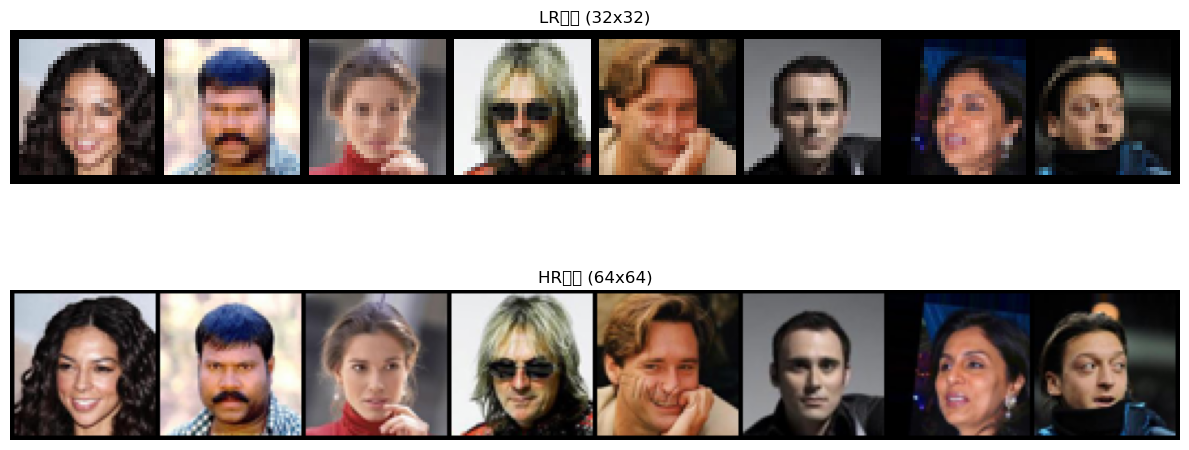

LR: torch.Size([8, 3, 32, 32]), HR: torch.Size([8, 3, 64, 64])


In [72]:
#可视化样本
sample_batch = next(iter(train_loader))
lr_batch = sample_batch['LR'][:8]
hr_batch = sample_batch['HR'][:8]

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

grid_lr = utils.make_grid(lr_batch, nrow=8, padding=2, normalize=True)
grid_hr = utils.make_grid(hr_batch, nrow=8, padding=2, normalize=True)

axes[0].imshow(grid_lr.permute(1, 2, 0))
axes[0].set_title(f'LR输入 (32x32)')
axes[0].axis('off')

axes[1].imshow(grid_hr.permute(1, 2, 0))
axes[1].set_title(f'HR目标 (64x64)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"LR: {lr_batch.shape}, HR: {hr_batch.shape}")

In [73]:
#初始化模型 
netG = FastRRDBNet(
    in_nc=cfg.IN_NC, out_nc=cfg.OUT_NC,
    nf=cfg.NF, nb=cfg.NB, scale=cfg.SCALE
).to(cfg.DEVICE)

netD = LightDiscriminator(in_nc=cfg.IN_NC, nf=cfg.NF).to(cfg.DEVICE)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Generator parameters: {count_parameters(netG):,}")
print(f"Discriminator parameters: {count_parameters(netD):,}")

# ==================== Cell 12: 损失和优化器 ====================

# 只用像素损失和GAN损失
cri_pix = nn.L1Loss().to(cfg.DEVICE)
cri_gan = nn.BCEWithLogitsLoss().to(cfg.DEVICE)

optimizer_G = torch.optim.Adam(
    netG.parameters(), lr=cfg.LR_G, betas=(cfg.BETA1, cfg.BETA2)
)

optimizer_D = torch.optim.Adam(
    netD.parameters(), lr=cfg.LR_D, betas=(cfg.BETA1, cfg.BETA2)
)



Generator parameters: 5,882,597
Discriminator parameters: 3,387,785


In [74]:
#训练函数
def train_one_epoch(epoch):
    """训练一个epoch"""
    netG.train()
    netD.train()
    
    epoch_losses = {'g_pix': 0, 'g_gan': 0, 'd_real': 0, 'd_fake': 0}
    
    for i, data in enumerate(train_loader):
        var_L = data['LR'].to(cfg.DEVICE)
        var_H = data['HR'].to(cfg.DEVICE)
        
        #训练生成器
        for p in netD.parameters():
            p.requires_grad = False
        
        optimizer_G.zero_grad()
        fake_H = netG(var_L)
        
        # 像素损失
        l_g_pix = cfg.PIXEL_WEIGHT * cri_pix(fake_H, var_H)
        
        # GAN损失
        pred_g_fake = netD(fake_H)
        pred_d_real = netD(var_H).detach()
        
        l_g_gan = cfg.GAN_WEIGHT * (
            cri_gan(pred_d_real - torch.mean(pred_g_fake), torch.zeros_like(pred_d_real)) +
            cri_gan(pred_g_fake - torch.mean(pred_d_real), torch.ones_like(pred_g_fake))
        ) / 2
        
        l_g_total = l_g_pix + l_g_gan
        l_g_total.backward()
        optimizer_G.step()
        
        epoch_losses['g_pix'] += l_g_pix.item()
        epoch_losses['g_gan'] += l_g_gan.item()
        
        #训练判别器
        for p in netD.parameters():
            p.requires_grad = True
        
        optimizer_D.zero_grad()
        
        pred_d_real = netD(var_H)
        pred_d_fake = netD(fake_H.detach())
        
        l_d_real = cri_gan(pred_d_real - torch.mean(pred_d_fake), torch.ones_like(pred_d_real))
        l_d_fake = cri_gan(pred_d_fake - torch.mean(pred_d_real), torch.zeros_like(pred_d_fake))
        l_d_total = (l_d_real + l_d_fake) / 2
        
        l_d_total.backward()
        optimizer_D.step()
        
        epoch_losses['d_real'] += l_d_real.item()
        epoch_losses['d_fake'] += l_d_fake.item()
        
        # 打印进度
        if i % cfg.LOG_INTERVAL == 0:
            print(f"[Epoch {epoch+1}/{cfg.NUM_EPOCHS}] [{i}/{len(train_loader)}] "
                  f"G_pix: {l_g_pix.item():.4f} | G_gan: {l_g_gan.item():.4f} | "
                  f"D: {l_d_real.item():.4f}")
    
    for k in epoch_losses:
        epoch_losses[k] /= len(train_loader)
    
    return epoch_losses



In [75]:
#验证函数=
def validate():
    """验证并可视化"""
    netG.eval()
    
    with torch.no_grad():
        val_batch = next(iter(val_loader))
        var_L = val_batch['LR'][:4].to(cfg.DEVICE)
        var_H = val_batch['HR'][:4].to(cfg.DEVICE)
        
        fake_H = netG(var_L)
        
        # 计算PSNR
        mse = F.mse_loss(fake_H, var_H)
        psnr = 10 * torch.log10(1 / mse)
        
        # 可视化
        lr = var_L.cpu()
        sr = fake_H.cpu()
        hr = var_H.cpu()
        lr_up = F.interpolate(lr, size=hr.shape[-2:], mode='bicubic', align_corners=False)
        
        fig, axes = plt.subplots(3, 4, figsize=(12, 9))
        for j in range(4):
            axes[0, j].imshow(lr_up[j].permute(1, 2, 0).clamp(0, 1))
            axes[0, j].set_title('双三次')
            axes[0, j].axis('off')
            
            axes[1, j].imshow(sr[j].permute(1, 2, 0).clamp(0, 1))
            axes[1, j].set_title('ESRGAN+注意力')
            axes[1, j].axis('off')
            
            axes[2, j].imshow(hr[j].permute(1, 2, 0))
            axes[2, j].set_title('真实HR')
            axes[2, j].axis('off')
        
        plt.suptitle(f'验证结果 - PSNR: {psnr.item():.2f} dB')
        plt.tight_layout()
        plt.show()
    
    netG.train()
    return psnr.item()


In [76]:
#1训练循环和日志记录
print("Starting fast ESRGAN training!")
print(f"Config: {cfg.HR_SIZE}x{cfg.HR_SIZE}, RRDB blocks={cfg.NB}, Batch={cfg.BATCH_SIZE}")
print("-" * 70)

training_start = time.time()
best_psnr = 0

epoch_g_pix = []
epoch_g_gan = []
epoch_d_real = []
epoch_d_fake = []
epoch_psnr = []
epoch_ssim = []

def validate_metrics():
    """Return PSNR and SSIM without visualization."""
    netG.eval()
    with torch.no_grad():
        batch = next(iter(val_loader))
        lr = batch["LR"].to(cfg.DEVICE)
        hr = batch["HR"].to(cfg.DEVICE)

        sr = netG(lr)

        # ----- PSNR -----
        mse = F.mse_loss(sr, hr).item()
        psnr_value = 10 * np.log10(1 / mse)

        # ----- SSIM -----
        hr_np = hr[0].permute(1, 2, 0).cpu().numpy()
        sr_np = sr[0].permute(1, 2, 0).cpu().numpy()
        ssim_value = ssim(hr_np, sr_np, channel_axis=2, data_range=1.0)

    netG.train()
    return psnr_value, ssim_value


# ==================== 训练循环 ====================
for epoch in range(cfg.NUM_EPOCHS):
    epoch_start = time.time()

    losses = train_one_epoch(epoch)

    # Save losses
    epoch_g_pix.append(losses["g_pix"])
    epoch_g_gan.append(losses["g_gan"])
    epoch_d_real.append(losses["d_real"])
    epoch_d_fake.append(losses["d_fake"])

    psnr_value, ssim_value = validate_metrics()
    epoch_psnr.append(psnr_value)
    epoch_ssim.append(ssim_value)

    if psnr_value > best_psnr:
        best_psnr = psnr_value
        print(f"New best PSNR: {best_psnr:.2f} dB")

    epoch_time = time.time() - epoch_start
    print(f"\nEpoch {epoch+1}/{cfg.NUM_EPOCHS} Finished")
    print(f"Time: {epoch_time/60:.2f} min")
    print(f"Losses | G_pix: {losses['g_pix']:.4f} | G_gan: {losses['g_gan']:.4f} | "
          f"D_real: {losses['d_real']:.4f} | D_fake: {losses['d_fake']:.4f}")
    print(f"Metrics | PSNR: {psnr_value:.2f} dB | SSIM: {ssim_value:.4f}")
 
    if (epoch + 1) % cfg.SAVE_INTERVAL == 0:
        torch.save(netG.state_dict(), CHECKPOINT_DIR / f"fast_epoch_{epoch+1}_G.pth")
        torch.save(netD.state_dict(), CHECKPOINT_DIR / f"fast_epoch_{epoch+1}_D.pth")
        print("Model checkpoint saved.")


total_time = time.time() - training_start
print(f"\nTraining complete!")
print(f"Total time: {total_time/60:.1f} minutes")
print(f"Best PSNR: {best_psnr:.2f} dB")
print(f"Models saved in: {CHECKPOINT_DIR}")


Starting fast ESRGAN training!
Config: 64x64, RRDB blocks=8, Batch=32
----------------------------------------------------------------------
[Epoch 1/20] [0/1485] G_pix: 0.4551 | G_gan: 0.0033 | D: 0.7326
[Epoch 1/20] [30/1485] G_pix: 0.0988 | G_gan: 0.0693 | D: 0.0001
[Epoch 1/20] [60/1485] G_pix: 0.0747 | G_gan: 0.0622 | D: 0.0000
[Epoch 1/20] [90/1485] G_pix: 0.0892 | G_gan: 0.0706 | D: 0.0000
[Epoch 1/20] [120/1485] G_pix: 0.0733 | G_gan: 0.0939 | D: 0.0000
[Epoch 1/20] [150/1485] G_pix: 0.1031 | G_gan: 0.0363 | D: 0.0655
[Epoch 1/20] [180/1485] G_pix: 0.0641 | G_gan: 0.0148 | D: 1.2697
[Epoch 1/20] [210/1485] G_pix: 0.0501 | G_gan: 0.0093 | D: 0.4678
[Epoch 1/20] [240/1485] G_pix: 0.0424 | G_gan: 0.0198 | D: 0.0881
[Epoch 1/20] [270/1485] G_pix: 0.0455 | G_gan: 0.0231 | D: 0.4469
[Epoch 1/20] [300/1485] G_pix: 0.0371 | G_gan: 0.0236 | D: 0.1187
[Epoch 1/20] [330/1485] G_pix: 0.0340 | G_gan: 0.0206 | D: 0.2730
[Epoch 1/20] [360/1485] G_pix: 0.0358 | G_gan: 0.0334 | D: 0.5197
[Epoch

# 